In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import time

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import (AdaBoostClassifier,
                              BaggingClassifier,
                              ExtraTreesClassifier,
                              GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.metrics import (accuracy_score,
                             auc,
                             classification_report,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score,
                             roc_auc_score,
                             roc_curve)
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


In [2]:
df = pd.read_csv("../data/external/Hotel Reservations.csv")

# 🇺🇸 Modeling Data - 🇧🇷 Modelando os Dados



## Label Encoder

🇺🇸 Label Encoding is a data preprocessing technique that converts categorical values (such as text or labels) into numerical values. This is useful because most machine learning algorithms require numerical input to work properly.

🇧🇷 O Label Encoding é uma técnica de pré-processamento de dados que converte valores categóricos (como textos ou rótulos) em valores numéricos. Isso é útil porque a maioria dos algoritmos de machine learning requer dados numéricos para funcionar corretamente.

In [3]:
label_encoder = LabelEncoder()
for col in ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'booking_status']:
    df[col] = label_encoder.fit_transform(df[col])

In [4]:
X = df.drop(['booking_status', 'Booking_ID'], axis=1)
y = df['booking_status']

## Over Sample

🇺🇸 Over Sampling is a technique used to deal with imbalanced datasets, where one class has significantly fewer examples than the other. This imbalance can hurt the performance of machine learning models, as they tend to favor the majority class.
The idea of Over Sampling is to increase the number of samples from the minority class, either by duplicating existing samples or by generating new synthetic ones (such as with the SMOTE algorithm), until both classes are more balanced. This helps the model learn patterns from both classes and improves its ability to generalize.

🇧🇷 O Over Sampling (ou superamostragem) é uma técnica usada para lidar com conjuntos de dados desbalanceados, onde uma das classes possui muito menos exemplos do que a outra. Esse desequilíbrio pode prejudicar o desempenho de modelos de machine learning, pois eles tendem a favorecer a classe majoritária.
Com o Over Sampling, a ideia é aumentar a quantidade de exemplos da classe minoritária, gerando cópias ou criando novos exemplos sintéticos (como com o algoritmo SMOTE), até que haja um equilíbrio entre as classes. Isso ajuda o modelo a aprender melhor os padrões das duas classes e melhorar sua capacidade de generalização.


In [5]:
oversample = SMOTE(random_state=42)
over_X, over_y = oversample.fit_resample(X, y)

In [6]:
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(
    over_X, over_y, test_size=0.2, stratify=over_y, random_state=42
)

## Standard Scaler

🇺🇸 Standard Scaler is a normalization technique that transforms the data so that it has a mean of 0 and a standard deviation of 1. This is done by subtracting the mean and dividing by the standard deviation for each numeric column.
This scaling is important because many machine learning algorithms (such as logistic regression, SVM, KNN, and neural networks) are sensitive to the scale of the data. By applying the Standard Scaler, we ensure that all variables contribute equally during training, preventing variables with larger values from dominating the learning process.

🇧🇷 O Standard Scaler é uma técnica de normalização que transforma os dados para que tenham média igual a 0 e desvio padrão igual a 1. Isso é feito subtraindo a média e dividindo pelo desvio padrão de cada coluna numérica.
Essa padronização é importante porque muitos algoritmos de machine learning (como regressão logística, SVM, KNN e redes neurais) são sensíveis à escala dos dados. Ao aplicar o Standard Scaler, garantimos que todas as variáveis tenham o mesmo peso na hora de treinar o modelo, evitando que variáveis com valores maiores dominem o aprendizado.

In [7]:
scaler = StandardScaler()
over_X_train = scaler.fit_transform(over_X_train)
over_X_test = scaler.transform(over_X_test)

## Training Models - Treinando os Modelos

In [10]:
models = [
    AdaBoostClassifier(random_state=ord("S")),
    BaggingClassifier(random_state=ord("S")),
    DecisionTreeClassifier(random_state=ord("S")),
    ExtraTreesClassifier(random_state=ord("S")),
    GradientBoostingClassifier(random_state=ord("S")),
    KNeighborsClassifier(),
    RandomForestClassifier(random_state=ord("S")),
    XGBClassifier(random_state=ord("S"), use_label_encoder=False, eval_metric='logloss'),
]

In [ ]:
def training_models(models, over_X_train, over_y_train, over_X_test, over_y_test):
    results = []

    for model in models:
        start = time.time()

        cv_results = cross_validate(
            model,
            over_X_train,
            over_y_train,
            cv=5,
            scoring=['accuracy', 'f1', 'roc_auc'],
            return_train_score=True
        )

        train_mean_accuracy = cv_results['train_accuracy'].mean()
        train_mean_roc_auc = cv_results['train_roc_auc'].mean()
        train_mean_f1 = cv_results['train_f1'].mean()

        model.fit(over_X_train, over_y_train)
        test_preds = model.predict(over_X_test)

        test_accuracy = accuracy_score(over_y_test, test_preds)
        test_roc_auc = roc_auc_score(over_y_test, test_preds)
        test_f1 = f1_score(over_y_test, test_preds)

        results_dict = {
            'model': model.__class__.__name__,
            'train_accuracy': train_mean_accuracy,
            'train_roc_auc': train_mean_roc_auc,
            'train_f1': train_mean_f1,
            'test_accuracy': test_accuracy,
            'test_roc_auc': test_roc_auc,
            'test_f1': test_f1,
            'time_taken': time.time() - start
        }
        results.append(results_dict)

    results_df = pd.DataFrame(results)
    results_df.set_index('model', inplace=True)
    results_df = results_df.sort_values(by='test_accuracy', ascending=False)

    return results_df

In [13]:
results_df = training_models(models, over_X_train, over_y_train, over_X_test, over_y_test)

/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:35] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/FelipePessoal/Developer/URI/topicos-especiais/hotel-reservations/hotel_reservations/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=

In [14]:
results_df

,train_accuracy,train_roc_auc,train_f1,test_accuracy,test_roc_auc,test_f1,time_taken
model,,,,,,,
RandomForestClassifier,0.994651,0.999545,0.994651,0.924559,0.924559,0.925203,13.717675
ExtraTreesClassifier,0.994657,0.999922,0.994652,0.916052,0.916052,0.916198,13.014593
BaggingClassifier,0.989103,0.999167,0.989079,0.910722,0.910722,0.909956,3.489235
XGBClassifier,0.925751,0.981741,0.926044,0.906724,0.906724,0.907520,2.039286
DecisionTreeClassifier,0.994657,0.999922,0.994652,0.891554,0.891554,0.891175,0.486065
KNeighborsClassifier,0.899844,0.969980,0.899642,0.867159,0.867159,0.866226,4.975628
GradientBoostingClassifier,0.840143,0.925602,0.840736,0.841533,0.841533,0.842148,12.096769
AdaBoostClassifier,0.780334,0.874430,0.784235,0.784338,0.784338,0.787432,2.908717


In [17]:
best_model_name = results_df.index[0]

best_model = [model for model in models if model.__class__.__name__ == best_model_name][0]
best_model.fit(over_X_train, over_y_train)

RandomForestClassifier(random_state=83)

# 🇺🇸 Best Model Evaluate - 🇧🇷 Avaliação do Melhor Modelo

In [20]:
y_pred = best_model.predict(over_X_test)
y_proba = best_model.predict_proba(over_X_test)[:, 1]

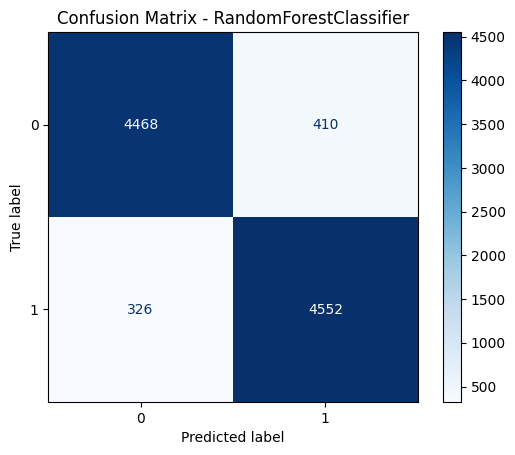

In [21]:
cm = confusion_matrix(over_y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

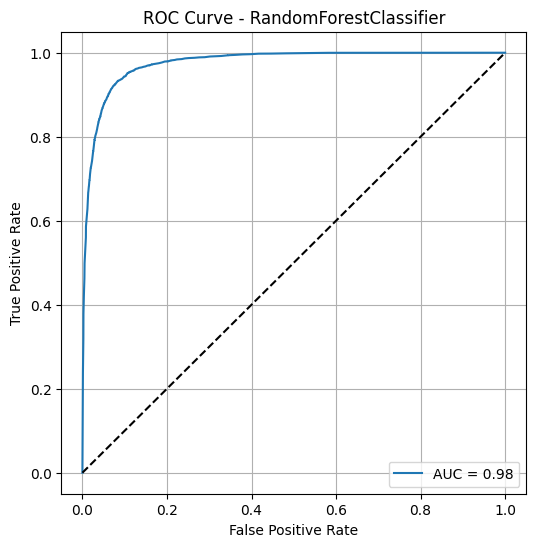

In [23]:
fpr, tpr, _ = roc_curve(over_y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name}')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# 🇺🇸 Tuning Models - 🇧🇷 Tunando Modelos